In [101]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


# 7日間ごとにデータを取得し、結合する関数
def get_last_days_data_in_chunks(ticker, interval="1m"):
    end_date = datetime.now()  # 現在の日付を終了日に設定
    start_date = end_date - timedelta(days=14)  # XX日前を開始日に設定
    all_data = pd.DataFrame()  # 取得した全データを格納するデータフレーム

    while start_date < end_date:
        # 7日間の終了日を設定
        period_end = min(start_date + timedelta(days=7), end_date)
        print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {period_end.strftime('%Y-%m-%d')}")
        
        # データの取得
        data = yf.download(ticker, interval=interval, start=start_date.strftime('%Y-%m-%d'), end=period_end.strftime('%Y-%m-%d'))
        
        # データを結合
        all_data = pd.concat([all_data, data])
        
        # 次の開始日に移動
        start_date = period_end

    return all_data

# データの取得
ticker = "^N225"
data = get_last_days_data_in_chunks(ticker)

# 取得したデータの確認
print(data)

Fetching data from 2025-01-15 to 2025-01-22
[*********************100%%**********************]  1 of 1 completed
Fetching data from 2025-01-22 to 2025-01-29
[*********************100%%**********************]  1 of 1 completed
                                   Open          High           Low  \
Datetime                                                              
2025-01-15 09:00:00+09:00  38721.609375  38748.070312  38718.550781   
2025-01-15 09:01:00+09:00  38727.988281  38771.789062  38725.398438   
2025-01-15 09:02:00+09:00  38764.570312  38774.988281  38742.320312   
2025-01-15 09:03:00+09:00  38742.789062  38754.109375  38720.941406   
2025-01-15 09:04:00+09:00  38721.160156  38733.539062  38713.718750   
...                                 ...           ...           ...   
2025-01-28 15:25:00+09:00  39060.281250  39060.281250  39060.281250   
2025-01-28 15:26:00+09:00  39060.281250  39060.281250  39060.281250   
2025-01-28 15:27:00+09:00  39060.281250  39060.281250  39060.281

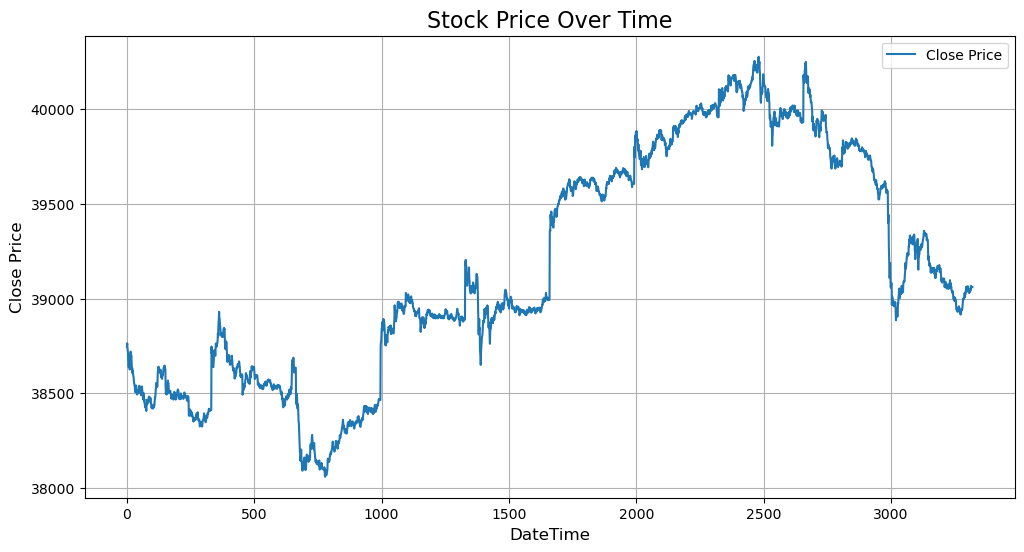

In [102]:
def plot_stock_data(data):
    if data.empty:
        print("No data available to plot.")
        return
    
    # 日時をリセット（必要に応じて調整）
    if 'Datetime' in data.columns:
        data['Datetime'] = pd.to_datetime(data['Datetime'])
    else:
        data = data.reset_index()
        data['Datetime'] = pd.to_datetime(data['index']) if 'index' in data.columns else data.index

    # 終値（Close）の可視化
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=data['Datetime'], y=data['Close'], label="Close Price")
    plt.title("Stock Price Over Time", fontsize=16)
    plt.xlabel("DateTime", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# 可視化の実行
plot_stock_data(data)


In [103]:
# 欠損値の確認
missing_values = data.isnull().sum()

print("欠損値の数:\n", missing_values)

# 欠損値のある行を削除
data = data.dropna()

欠損値の数:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [104]:
# 四本値の範囲を確認（負の値や極端に高い値を検出）
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    print(f'{column} の異常値:', data[(data[column] < 0) | (data[column] > data[column].mean() + 3 * data[column].std())])

# 異常値を補正（例: 負の値を0に置き換える）
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data[column] = np.where(data[column] < 0, 0, data[column])

Open の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
High の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Low の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Close の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Volume の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


In [105]:
# 必要な列のみを選択して標準化
scaler = StandardScaler()
data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [106]:
# 必要な列のみを選択
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# 1. 5期間移動平均
data['SMA_5'] = data['Close'].rolling(window=5).mean()

# 2. 20期間移動平均
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# 4. 短期・中期移動平均差分（5期間 - 20期間）
data['SMA_diff_5_20'] = data['SMA_5'] - data['SMA_20']

# 5. ボリンジャーバンド上限（20期間）
data['BB_upper'] = data['SMA_20'] + (data['Close'].rolling(window=20).std() * 2)

# 6. ボリンジャーバンド下限（20期間）
data['BB_lower'] = data['SMA_20'] - (data['Close'].rolling(window=20).std() * 2)

# 7. ボリンジャーバンド幅
data['BB_width'] = data['BB_upper'] - data['BB_lower']

# 8. 標準偏差（20期間）
data['Volatility_20'] = data['Close'].rolling(window=20).std()

# 9. ATR（平均値レンジ）
data['Prev_Close'] = data['Close'].shift(1)  # 前日の終値を新しい列に保存

data['TR'] = data[['High', 'Low', 'Prev_Close']].apply(
    lambda x: max(
        x['High'] - x['Low'],
        abs(x['High'] - x['Prev_Close']),
        abs(x['Low'] - x['Prev_Close'])
    ),
    axis=1
)

data['ATR_14'] = data['TR'].rolling(window=14).mean()

# 'Prev_Close'列は不要なので削除する場合は次の行を追加
data.drop(columns=['Prev_Close'], inplace=True)


# 10. RSI（14期間）
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# 11. MACD
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']

# 12. MACDシグナル
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# 13. MACDヒストグラム
data['MACD_histogram'] = data['MACD'] - data['MACD_signal']

# 14. ストキャスティクス（%K）
data['L14'] = data['Low'].rolling(window=14).min()
data['H14'] = data['High'].rolling(window=14).max()
data['%K'] = (data['Close'] - data['L14']) * 100 / (data['H14'] - data['L14'])

# 15. ストキャスティクス（%D）
data['%D'] = data['%K'].rolling(window=3).mean()

# 17. 移動平均の傾き（20期間）
data['SMA_slope_20'] = data['SMA_20'].diff()

# 18. サポートラインとの距離
data['Support_Distance'] = data['Low'] - data['Low'].rolling(window=20).min()

# 19. レジスタンスラインとの距離
data['Resistance_Distance'] = data['High'].rolling(window=20).max() - data['High']

# 20. 価格変化率（5期間）
data['Price_Change_5'] = data['Close'].pct_change(periods=5)

# 21. 価格変化率（20期間）
data['Price_Change_20'] = data['Close'].pct_change(periods=20)

# 22. 瞬間ボラティリティ（差分平方）
data['Instant_Volatility'] = data['Close'].diff().pow(2).rolling(window=5).sum()

# 23. エンベロープ（±2%）
data['Envelope_upper'] = data['SMA_20'] * 1.02
data['Envelope_lower'] = data['SMA_20'] * 0.98

# 24. DMIのADX（14期間）
data['Plus_DM'] = data['High'].diff()
data['Minus_DM'] = -data['Low'].diff()
data['Plus_DI'] = 100 * (data['Plus_DM'].where(data['Plus_DM'] > 0, 0)).ewm(alpha=1/14, min_periods=0).mean() / data['ATR_14']
data['Minus_DI'] = 100 * (data['Minus_DM'].where(data['Minus_DM'] > 0, 0)).ewm(alpha=1/14, min_periods=0).mean() / data['ATR_14']
data['DX'] = (abs(data['Plus_DI'] - data['Minus_DI']) / abs(data['Plus_DI'] + data['Minus_DI'])) * 100
data['ADX'] = data['DX'].ewm(alpha=1/14, min_periods=0).mean()

# 25. 移動平均乖離率（20期間）
data['MA_deviation_20'] = (data['Close'] - data['SMA_20']) / data['SMA_20']

# 26. ウィリアムズ％R（14期間）
data['Williams_R'] = (data['H14'] - data['Close']) / (data['H14'] - data['L14']) * -100

# 27. 終値/始値の比率
data['Close_to_Open'] = data['Close'] / data['Open']

# 28. 終値の変化幅（前日比）
data['Close_Change'] = data['Close'].diff()

# 29. 終値の変化率（前日比、パーセンテージ）
data['Close_Pct_Change'] = data['Close'].pct_change() * 100

# 30. 前のローソク足との比率
data['Previous_Ratio'] = data['Close'] / data['Close'].shift(1)

# 欠損値の発生する先頭行を削除
data = data.dropna()

print(data)

                               Open      High       Low     Close  \
Datetime                                                            
2025-01-15 09:20:00+09:00 -0.863269 -0.871960 -0.877293 -0.886908   
2025-01-15 09:21:00+09:00 -0.883148 -0.851687 -0.869824 -0.880306   
2025-01-15 09:22:00+09:00 -0.884099 -0.896511 -0.929222 -0.926623   
2025-01-15 09:23:00+09:00 -0.925643 -0.915146 -0.912800 -0.902276   
2025-01-15 09:24:00+09:00 -0.913534 -0.922873 -0.923990 -0.919797   
...                             ...       ...       ...       ...   
2025-01-28 15:25:00+09:00 -0.179419 -0.192193 -0.166009 -0.178884   
2025-01-28 15:26:00+09:00 -0.179419 -0.192193 -0.166009 -0.178884   
2025-01-28 15:27:00+09:00 -0.179419 -0.192193 -0.166009 -0.178884   
2025-01-28 15:28:00+09:00 -0.179419 -0.192193 -0.166009 -0.178884   
2025-01-28 15:29:00+09:00 -0.179419 -0.192193 -0.166009 -0.178884   

                              Adj Close  Volume     SMA_5    SMA_20  \
Datetime                       

In [107]:
# 終値の1日後の値を追加
data['Next_Close'] = data['Close'].shift(-1)

# 終値が上がるか下がるかのラベルを作成
#　Tureなら1、Falseなら0
data.loc[:, 'Price_Up'] = (data['Next_Close'] > data['Close']).astype(int)

# 最後の行は次の値がないため削除
data = data.dropna()

print(data[[ 'Close', 'Next_Close', 'Price_Up']].head())

                              Close  Next_Close  Price_Up
Datetime                                                 
2025-01-15 09:20:00+09:00 -0.886908   -0.880306         1
2025-01-15 09:21:00+09:00 -0.880306   -0.926623         0
2025-01-15 09:22:00+09:00 -0.926623   -0.902276         1
2025-01-15 09:23:00+09:00 -0.902276   -0.919797         0
2025-01-15 09:24:00+09:00 -0.919797   -0.951851         0


In [108]:
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'SMA_20', 'SMA_diff_5_20', 
                    'BB_upper', 'BB_lower', 'BB_width', 'Volatility_20', 'ATR_14', 'RSI_14', 
                    'MACD', 'MACD_signal', 'MACD_histogram', '%K', '%D', 'SMA_slope_20', 
                    'Support_Distance', 'Resistance_Distance', 'Price_Change_5', 'Price_Change_20', 
                    'Instant_Volatility', 'Envelope_upper', 'Envelope_lower', 'Plus_DI', 
                    'Minus_DI', 'DX', 'ADX', 'MA_deviation_20', 'Williams_R', 'Close_to_Open', 
                    'Close_Change', 'Close_Pct_Change', 'Previous_Ratio']

# 特徴量とラベルの定義
X = data[columns_to_scale]
y = data['Price_Up']

In [109]:
#単純なランダムフォレストによる勝率の計算
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレストの学習と予測
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 正解率の計算
accuracy = accuracy_score(y_test, y_pred)
print(f'ランダムフォレストのAccuracy: {accuracy:.3f}')

ランダムフォレストのAccuracy: 0.505


In [110]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_precision_recall_f1(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    print(f"適合率 (Precision): {precision:.3f}")
    print(f"再現率 (Recall): {recall:.3f}")
    print(f"F1スコア: {f1:.3f}")
    
# 特徴量選定 + ハイパーパラメータの設定後の評価
evaluate_precision_recall_f1(y_test, y_pred)

適合率 (Precision): 0.478
再現率 (Recall): 0.446
F1スコア: 0.461


In [59]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# ==============================
# Step 1: 特徴量選定 (RFE)
# ==============================
# ランダムフォレストモデルを初期化
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# RFEで特徴量を選定（10個）a
rfe = RFE(estimator=rf_model, n_features_to_select=10)
rfe.fit(X, y)

# 選ばれた特徴量
selected_features_rfe = X.columns[rfe.support_]
print("RFEで選ばれた特徴量:", selected_features_rfe)

# 選ばれた特徴量だけでデータを再構築
X_rfe_selected = X[selected_features_rfe]

# ==============================
# Step 2: ハイパーパラメータチューニング
# ==============================
# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_rfe_selected, y, test_size=0.2, random_state=42, shuffle=False)

# ハイパーパラメータの設定
param_grid = {
    'n_estimators': [50, 100, 200],      # 木の本数
    'max_depth': [None, 10, 20],         # 木の深さ
    'min_samples_split': [2, 5, 10],     # 分割するための最小サンプル数
    'min_samples_leaf': [1, 2, 4],       # 葉ノードの最小サンプル数
    'max_features': ['sqrt', 'log2']     # 各分割で考慮する特徴量の数
}

# GridSearchCVを初期化
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                    cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# ハイパーパラメータチューニングの実行
grid_search.fit(X_train, y_train)

# 最適なハイパーパラメータの表示
best_params = grid_search.best_params_
print(f'最適なハイパーパラメータ: {best_params}')

# ==============================
# Step 3: 最適パラメータでモデルを再構築
# ==============================
# 最適なパラメータを使ってモデルを再構築
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# テストデータで予測
y_pred = best_rf_model.predict(X_test)

# 勝率（Accuracy）を計算
accuracy = accuracy_score(y_test, y_pred)
print(f'ランダムフォレストモデルの勝率（Accuracy）: {accuracy:.3f}')

# ==============================
# Step 4: 勝率の詳細な確認（上がる・下がる）
# ==============================
import numpy as np

# 上がる・下がるの予測勝率をそれぞれ計算
actual_up = (y_test == 1)  # 実際に値が上がった場合
actual_down = (y_test == 0)  # 実際に値が下がった場合

pred_up_correct = np.sum((y_pred == 1) & actual_up)
pred_down_correct = np.sum((y_pred == 0) & actual_down)

up_accuracy = pred_up_correct / np.sum(actual_up) if np.sum(actual_up) > 0 else 0
down_accuracy = pred_down_correct / np.sum(actual_down) if np.sum(actual_down) > 0 else 0

print(f'値上がりを当てた勝率: {up_accuracy:.3f}')
print(f'値下がりを当てた勝率: {down_accuracy:.3f}')


RFEで選ばれた特徴量: Index(['SMA_diff_5_20', 'BB_upper', 'ATR_14', 'MACD_histogram', '%K', '%D',
       'SMA_slope_20', 'DX', 'Close_to_Open', 'Previous_Ratio'],
      dtype='object')
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.0s
[CV] END max_depth=20, max_features=sqrt, mi

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_precision_recall_f1(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    print(f"適合率 (Precision): {precision:.3f}")
    print(f"再現率 (Recall): {recall:.3f}")
    print(f"F1スコア: {f1:.3f}")
    
# 特徴量選定 + ハイパーパラメータの設定後の評価
evaluate_precision_recall_f1(y_test, y_pred)


In [99]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
# 特徴量選定 (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]
X_rfe_selected = X[selected_features_rfe]

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X_rfe_selected, y, test_size=0.2, random_state=42, shuffle=False)

# デフォルト設定のランダムフォレスト
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 勝率計算
accuracy = accuracy_score(y_test, y_pred)
print(f'特徴量選定のみ実施時の勝率: {accuracy:.3f}')


特徴量選定のみ実施時の勝率: 0.506


In [100]:
# 特徴量選定のみでの評価
evaluate_precision_recall_f1(y_test, y_pred)

適合率 (Precision): 0.517
再現率 (Recall): 0.455
F1スコア: 0.484


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
# データ分割（元の全特徴量を使用）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# ハイパーパラメータの設定とGridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# 最適パラメータでモデルを構築
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

# 勝率計算
accuracy = accuracy_score(y_test, y_pred)
print(f'ハイパーパラメータ設定のみ実施時の勝率: {accuracy:.3f}')


In [ ]:
# パラメータの設定のみでの評価
evaluate_precision_recall_f1(y_test, y_pred)